In [15]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [32]:
max_samples = 100

# data_name = "flash fiction"
# data_locations = {
#     "GPT-3": "../machine_data_stories/embeddings/GPT3_temp1.0_flash_fiction_nocrea100_vecs.json",
#     "GPT-3 (High Temp.)": "../machine_data_stories/embeddings/GPT3_temp1.2_flash_fiction_nocrea_vecs.json",
#     "GPT-4": "../machine_data_stories/embeddings/GPT4_temp1.0_flash_fiction_nocrea100_vecs.json",
#     "GPT-4 (High Temp.)": "../machine_data_stories/embeddings/GPT4_temp1.2_flash_fiction_nocrea_vecs.json",
# }

data_name = "Haiku"
data_locations = {
    "GPT-3": "../machine_data_stories/embeddings/GPT3_temp1.0_haiku_nocrea100_vecs.json",
    "GPT-3 (High Temp.)": "../machine_data_stories/embeddings/GPT3_temp1.5_haiku_nocrea_vecs.json",
    "GPT-4": "../machine_data_stories/embeddings/GPT4_temp1.0_haiku_nocrea100_vecs.json",
    "GPT-4 (High Temp.)": "../machine_data_stories/embeddings/GPT4_temp1.5_haiku_nocrea_vecs.json",
    "Human": "../machine_data_stories/embeddings/human_haiku_tempslibres_vecs.json",
}

# data_name = "Synopsis"
# data_locations = {
#     "GPT-3": "../machine_data_stories/embeddings/GPT3_temp1.0_synopsis_nocrea100_vecs.json",
#     "GPT-3 (High Temp.)": "../machine_data_stories/embeddings/GPT3_temp1.2_synopsis_nocrea_vecs.json",
#     "GPT-4": "../machine_data_stories/embeddings/GPT4_temp1.0_synopsis_nocrea100_vecs.json",
#     "GPT-4 (High Temp.)": "../machine_data_stories/embeddings/GPT4_temp1.2_synopsis_nocrea_vecs.json",
# }

data = {}
for name, loc in data_locations.items():
    data[name] = np.array(list(json.load(open(loc, "r")).values()))[:max_samples]

print("Number of samples per model:")
for name, vecs in data.items():
    print(name, vecs.shape[0])

Number of samples per model:
GPT-3 93
GPT-3 (High Temp.) 98
GPT-4 98
GPT-4 (High Temp.) 100
Human 100


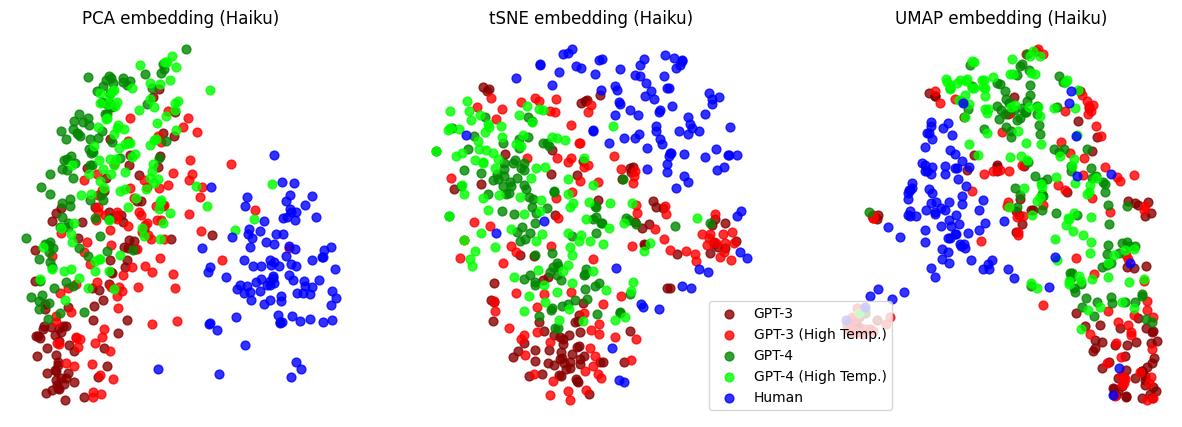

In [55]:
def plot_embedding(data, data_name, embedding_type="tSNE", colors=None, kde=False, legend=True, show=True):
    vecs_all = np.concatenate(list(data.values()))
    model_ids = np.concatenate([[i] * len(vecs) for i, vecs in enumerate(data.values())])

    if embedding_type.lower() == "tsne":
        emb = TSNE(n_components=2)
    elif embedding_type.lower() == "pca":
        emb = PCA(n_components=2)
    elif embedding_type.lower() == "umap":
        emb = UMAP(n_components=2)
    else:
        raise ValueError(f"Unknown embedding type {embedding_type}")

    emb_vecs = emb.fit_transform(vecs_all)

    plt.title(f"{embedding_type} embedding ({data_name})")
    for i, name in enumerate(data.keys()):
        cluster_data = emb_vecs[model_ids == i].T
        c = colors[i] if colors is not None else f"C{i}"
        plt.scatter(*cluster_data, label=name, alpha=0.8, s=40, c=c)

        if kde:
            sns.kdeplot(x=cluster_data[0], y=cluster_data[1], fill=True, color=c, alpha=0.1, thresh=0.01, levels=2)

    plt.axis("off")
    if legend:
        plt.legend()
    if show:
        plt.show()

colors = ["#880000", "#ff0000", "#008800", "#00ff00", "#0000ff"]

plt.figure(figsize=(15, 5))
plt.subplot(131)
plot_embedding(data, data_name, embedding_type="PCA", colors=colors, legend=False, show=False)
plt.subplot(132)
plot_embedding(data, data_name, embedding_type="tSNE", colors=colors, legend=False, show=False)
plt.subplot(133)
plot_embedding(data, data_name, embedding_type="UMAP", colors=colors, legend=False, show=False)
plt.legend(loc="lower right", bbox_to_anchor=(0.2, 0))